<a href="https://colab.research.google.com/github/jingxuchen19/ECON5200-Applied-Data-Analytics-in-Economics/blob/main/Class%204/Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64


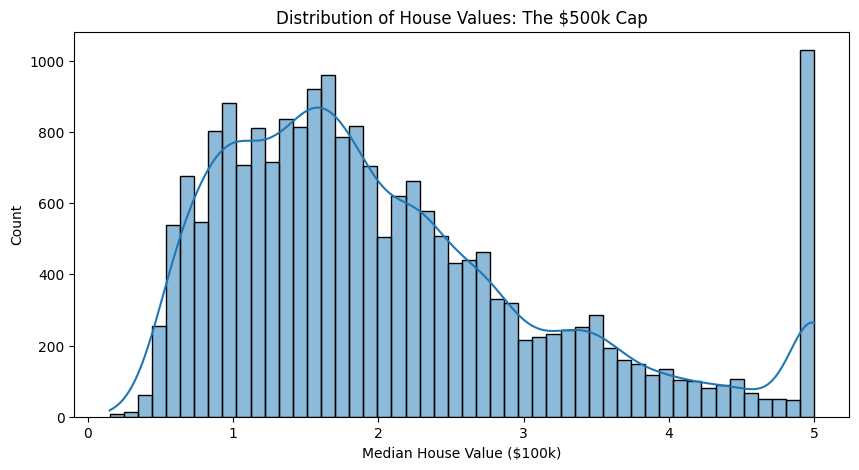

In [ ]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 1. Ingest Data
data = fetch_california_housing(as_frame=True)
df = data.frame

# 2. Inspect the "Ceiling Effect"
print(df['MedHouseVal'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df['MedHouseVal'], bins=50, kde=True)
plt.title("Distribution of House Values: The $500k Cap")
plt.xlabel("Median House Value ($100k)")
plt.show()

In [ ]:
def flag_outliers_iqr(df, column):
  # Calculate Quartiles
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1

  # Define the "Tukey Fence"
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Return Boolean Mask
  return (df[column] < lower_bound) | (df[column] > upper_bound)

# Apply to Median Income
df['outlier_iqr'] = flag_outliers_iqr(df, 'MedInc')

print(f"Manual Outliers Detected: {df['outlier_iqr'].sum()}")
print("These are primarily the 'Wealthy' districts.")

Manual Outliers Detected: 681
These are primarily the 'Wealthy' districts.


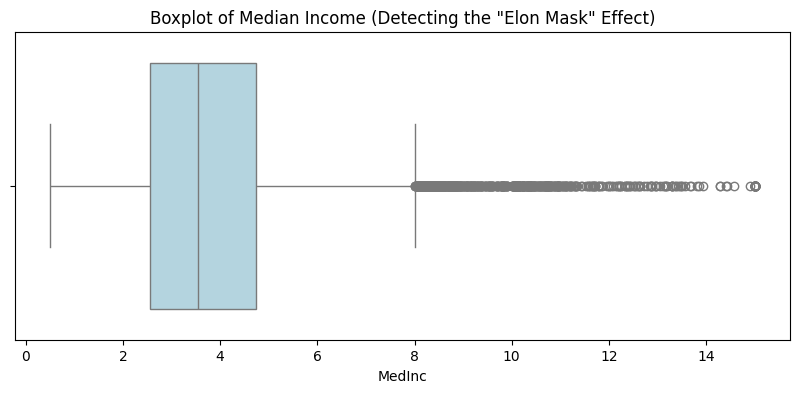

In [ ]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['MedInc'], color='lightblue')
plt.title('Boxplot of Median Income (Detecting the "Elon Mask" Effect)')
plt.show()

In [ ]:
# Initialize the model
# contamination=0.05: We estimate ~5% of the data is anomalous
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Features to analyze (Income, House Age, Average Rooms)
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population']

# Fit and Predict (-1 = Outlier, 1 = Normal)
preds = iso_forest.fit_predict(df[features])

# Map to boolean (True if outlier)
df['outlier_iso'] = preds == -1

print(f"Algorithmic Outliers Detected: {df['outlier_iso'].sum()}")

Algorithmic Outliers Detected: 1032


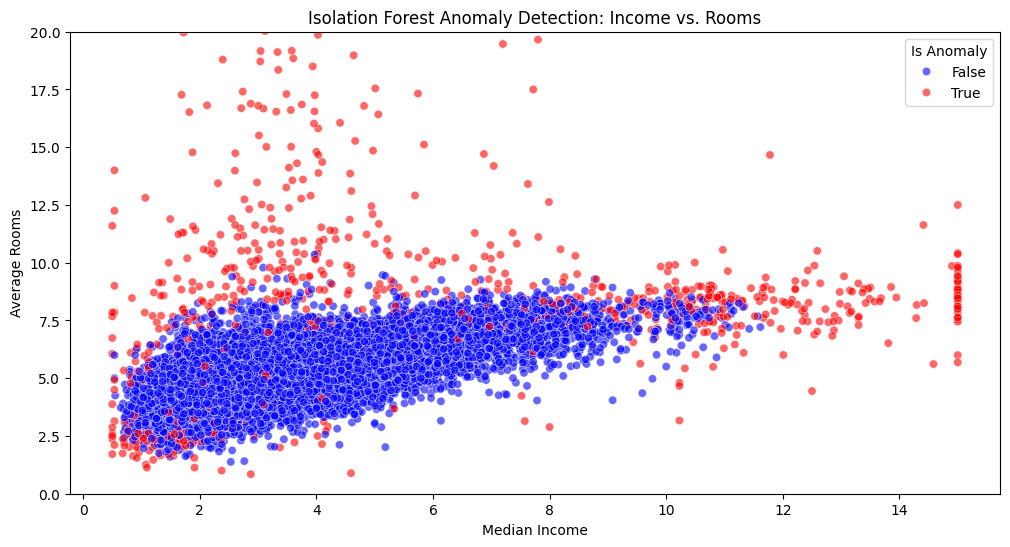

In [ ]:
plt.figure(figsize=(12, 6))

# Plot points flagged by Isolation Forest
sns.scatterplot(
    data=df,
    x='MedInc',
    y='AveRooms',
    hue='outlier_iso',
    palette={True: 'red', False: 'blue'},
    alpha=0.6
)

plt.title("Isolation Forest Anomaly Detection: Income vs. Rooms")
plt.xlabel("Median Income")
plt.ylabel("Average Rooms")
plt.ylim(0, 20) # Zoom in to ignore extreme errors
plt.legend(title='Is Anomaly')
plt.show()

=== Comparative Forensics Report: Core Market vs. Tail ===


Mean            Median                Std                MAD  \
Group          Normal   Outlier  Normal  Outlier    Normal   Outlier   Normal   
Variable                                                                        
MedHouseVal  2.037000  2.668172  1.7890  2.05700  1.114117  1.634770  0.67400   
MedInc       3.769613  5.790782  3.5156  4.25695  1.640561  4.145354  1.03165   

                    Inequality_Wedge (Mean-Median)            
Group       Outlier                         Normal   Outlier  
Variable                                                      
MedHouseVal  1.1030                       0.248000  0.611172  
MedInc       2.4919                       0.254013  1.533832


=== Inequality Wedge (Outliers Only) ===


,Variable,Inequality_Wedge (Mean-Median)
2,MedInc,1.533832
3,MedHouseVal,0.611172


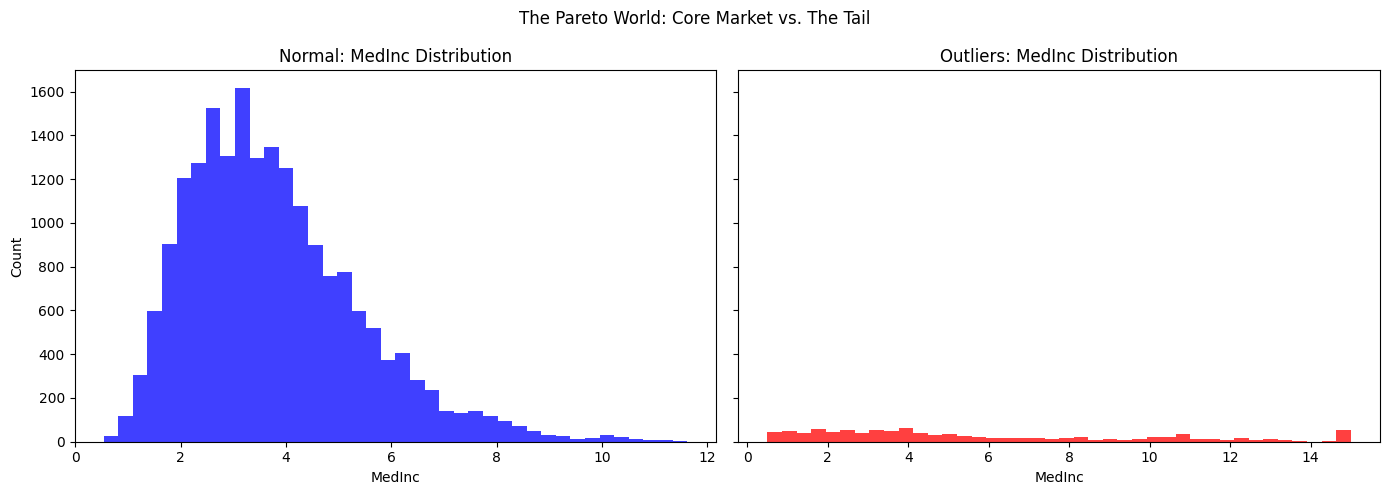

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Split data
df_normal = df[df["outlier_iso"] == False].copy()
df_outlier = df[df["outlier_iso"] == True].copy()

# Helper: Median Absolute Deviation (MAD)
def mad(series: pd.Series) -> float:
    s = series.dropna()
    med = s.median()
    return (s - med).abs().median()

# 2) Mean + Median for MedInc and MedHouseVal (both groups)
# 3) Std vs MAD (volatility)
metrics = {
    "Mean": "mean",
    "Median": "median",
    "Std": "std",
    "MAD": mad
}

rows = []
for group_name, dfg in [("Normal", df_normal), ("Outlier", df_outlier)]:
    for col in ["MedInc", "MedHouseVal"]:
        stats = {
            "Group": group_name,
            "Variable": col,
            "Mean": dfg[col].mean(),
            "Median": dfg[col].median(),
            "Std": dfg[col].std(),
            "MAD": mad(dfg[col]),
        }
        stats["Inequality_Wedge (Mean-Median)"] = stats["Mean"] - stats["Median"]
        rows.append(stats)

summary = pd.DataFrame(rows)

# Make it a cleaner pivot-style table for display
summary_table = summary.pivot(index="Variable", columns="Group", values=[
    "Mean", "Median", "Std", "MAD", "Inequality_Wedge (Mean-Median)"
])

print("=== Comparative Forensics Report: Core Market vs. Tail ===")
display(summary_table)

# 4) Show the 'Inequality Wedge' for outliers (Mean - Median)
outlier_wedge = summary[summary["Group"] == "Outlier"][["Variable", "Inequality_Wedge (Mean-Median)"]]
print("\n=== Inequality Wedge (Outliers Only) ===")
display(outlier_wedge)

# Visualization: 1x2 subplot histograms for MedInc
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].hist(df_normal["MedInc"].dropna(), bins=40, color="blue", alpha=0.75)
axes[0].set_title("Normal: MedInc Distribution")
axes[0].set_xlabel("MedInc")
axes[0].set_ylabel("Count")

axes[1].hist(df_outlier["MedInc"].dropna(), bins=40, color="red", alpha=0.75)
axes[1].set_title("Outliers: MedInc Distribution")
axes[1].set_xlabel("MedInc")

plt.suptitle("The Pareto World: Core Market vs. The Tail")
plt.tight_layout()
plt.show()